In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py 
import matlab_helpers as mh 
# from sklearn.model_selection import test_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import copy 
from scipy.io import savemat

ModuleNotFoundError: No module named 'matlab_helpers'

## Load dataset 
Steps are 
1. Load training data 
2. To use the parallel training, need to use the same length

In [ ]:
root_out_dir = '../Datasets/sgRNN_vIHC/PyData/'
train_dataset = np.load(root_out_dir + 'sgRNN_data_train_file.npz', allow_pickle=True)
print(train_dataset.files)

X_train = train_dataset["data_sgRNN_x"][:] # your train set features
y_train = to_categorical(np.ravel(np.array(train_dataset["data_label_y"][:]))) # your train set labels

# Preprocess to make the data the same length 
train_len_pre = np.array([item.shape[1] for item in X_train])
min_val = np.array([np.min(np.ravel(item)) for item in X_train])
max_val = np.array([np.max(np.ravel(item)) for item in X_train])

max_len = train_len_pre.max()
X_train = [np.concatenate([-(2**7)*np.ones((item.shape[0], max_len-item.shape[1])), item],axis=1) for item in X_train]
train_len_post = np.array([item.shape[1] for item in X_train])
X_train = np.asarray(X_train, dtype=np.int8)
X_train = np.transpose(X_train, (0, 2, 1))

print(X_train.shape)

# If we want to train using clean calls only, then take the last 1203 points from the training dataset
X_train_clean = X_train[-1203:,:,:]
y_train_clean = y_train[-1203:,:]

test_dataset = np.load(root_out_dir + 'sgRNN_data_test_snrInf.npz', allow_pickle=True)
print(test_dataset)
X_test = test_dataset["data_sgRNN_x"][:] # your train set features
X_test = [np.concatenate([-(2**7)*np.ones((item.shape[0], max_len-item.shape[1])), item],axis=1) for item in X_test]
X_test = np.asarray(X_test, dtype=np.int8)
X_test = np.transpose(X_test, (0, 2, 1))
y_test = to_categorical(np.ravel(np.array(test_dataset["data_label_y"][:]))) # your train set labels

print(f"Type: X_train={type(X_train)}, y_train={type(y_train)}")
print(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape},X_test={X_test.shape}, y_test={y_test.shape}")

unq_vals, unq_counts = np.unique(y_train, axis=0, return_counts=True)
print(f"unq_vals={unq_vals}, unq_counts={unq_counts}")

['data_sgRNN_x', 'data_label_y', 'data_filename']


ValueError: setting an array element with a sequence.

## Create an RNN to fit using noisy data 

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Bidirectional
tf.random.set_seed(1234)  # applied to achieve consistent results

RNNmodel_noisy = tf.keras.models.Sequential()
# RNNmodel_noisy.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(73, 67)))

RNNmodel_noisy.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(None, 67)))
RNNmodel_noisy.add(Bidirectional(LSTM(20, return_sequences=False)))

# Take home for unidirectional LSTM: those are hopeless
# RNNmodel_noisy.add(LSTM(67, return_sequences=True, input_shape=(73, 67)))
# RNNmodel_noisy.add(LSTM(67, return_sequences=True))
# RNNmodel_noisy.add(LSTM(67, return_sequences=False))
RNNmodel_noisy.add(Dense(5, activation='softmax'))

RNNmodel_noisy.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
RNNmodel_noisy.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
history_noisy = RNNmodel_noisy.fit(train_dataset, epochs=100, validation_data=test_dataset)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_55 (Bidirecti  (None, 73, 40)           14080     
 onal)                                                           
                                                                 
 bidirectional_56 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_34 (Dense)            (None, 5)                 205       
                                                                 
Total params: 24,045
Trainable params: 24,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 74/170 [============>.................] - ETA: 2s - loss: 1.4421 - accuracy: 0.3319

KeyboardInterrupt: 

## Create an RNN to fit using clean data 

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Bidirectional
tf.random.set_seed(1234)  # applied to achieve consistent results

RNNmodel_clean = tf.keras.models.Sequential()
# RNNmodel_clean.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(73, 67)))

RNNmodel_clean.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(None, 67)))
RNNmodel_clean.add(Bidirectional(LSTM(10, return_sequences=False)))
# RNNmodel_clean.add(LSTM(67, return_sequences=True, input_shape=(73, 67)))
# RNNmodel_clean.add(LSTM(67, return_sequences=False))
RNNmodel_clean.add(Dense(5, activation='softmax'))

RNNmodel_clean.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
RNNmodel_clean.summary()

train_dataset_clean = tf.data.Dataset.from_tensor_slices((X_train_clean, y_train_clean)).batch(32)
history_clean = RNNmodel_clean.fit(train_dataset_clean, epochs=100, validation_data=test_dataset)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_57 (Bidirecti  (None, None, 20)         6240      
 onal)                                                           
                                                                 
 bidirectional_58 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_35 (Dense)            (None, 5)                 105       
                                                                 
Total params: 8,825
Trainable params: 8,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
38/38 [==============================] - 7s 65ms/step - loss: 1.4335 - accuracy: 0.3458 - val_loss: 1.2731 - val_accuracy: 0.5686
Epoch 2/100
38/38 [======================

KeyboardInterrupt: 

## Get training fit 

13/13 [==============================] - 0s 7ms/step
Unique values in y_train_pred_NN=[0 1 2 3]
Unique values in y_test_pred_NN=[0 1 2 3]
Training accuracy=0.455452865064695
 Testing accuracy=0.7556109725685786



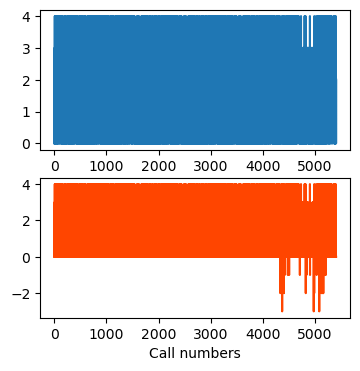

In [ ]:
y_train_pred_NN_clean = np.argmax(RNNmodel_clean.predict(X_train_clean), axis=1)
y_train_true_clean= np.argmax(y_train_clean, axis=1)
train_accuracy_cleanRNN = np.sum(y_train_true_clean==y_train_pred_NN_clean)/len(y_train_true_clean)

y_train_pred_NN_noisy = np.argmax(RNNmodel_noisy.predict(X_train), axis=1)
y_test_pred_NN_noisy = np.argmax(RNNmodel_noisy.predict(X_test), axis=1)
y_train_true_noisy= np.argmax(y_train, axis=1)
y_test_true_noisy= np.argmax(y_test, axis=1)
train_accuracy_noisyRNN = np.sum(y_train_true_noisy==y_train_pred_NN_noisy)/len(y_train)

print(f"Unique values in y_train_pred_NN={np.unique(y_train_pred_NN_noisy)}")
print(f"Unique values in y_test_pred_NN={np.unique(y_test_pred_NN_noisy)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_true_noisy)
ax[1].plot(y_train_true_noisy-y_train_pred_NN_noisy, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={train_accuracy_noisyRNN}\n Testing accuracy={np.sum(y_test_true_noisy==y_test_pred_NN_noisy)/len(y_test_true_noisy)}\n")

Test in different SNRs 

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr-20.npz
13/13 [==============================] - 0s 7ms/step
Testing accuracy: Noisy = 0.26683291770573564, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr-15.npz
13/13 [==============================] - 0s 6ms/step
Testing accuracy: Noisy = 0.26683291770573564, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr-10.npz
13/13 [==============================] - 0s 8ms/step
Testing accuracy: Noisy = 0.26683291770573564, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr-5.npz
13/13 [==============================] - 0s 7ms/step
Testing accuracy: Noisy = 0.26683291770573564, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr0.npz
13/13 [==============================] - 0s 6ms/step
Testing accuracy: Noisy = 0.26683291770573564, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr5.npz
13/13 [==============================] - 0s 6ms/step
Testing accuracy: Noisy = 0.26683291770573564, clean = 

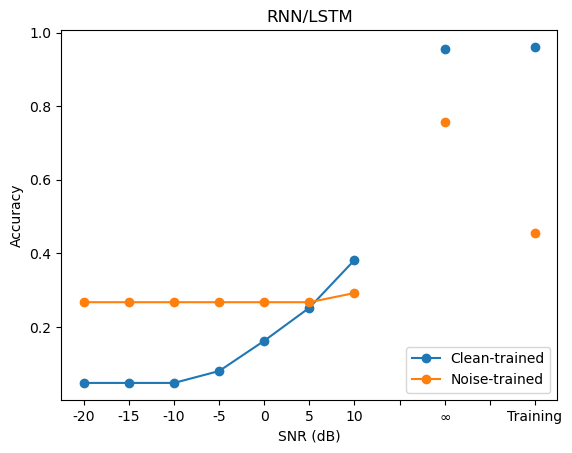

In [ ]:
doSaveData = False
all_snrs= np.arange(-20.0, 11, 5)
all_snrs= np.append(all_snrs, np.inf)

test_accuracy_noisyRNN = np.zeros((all_snrs.shape))
test_accuracy_cleanRNN = np.zeros((all_snrs.shape))

for snr_value,iter in zip(all_snrs,range(all_snrs.shape[0])):
    if np.isinf(snr_value):
        out_sgRNN_data_test_file= root_out_dir + 'sgRNN_data_test_snrInf.npz'
    else: 
        out_sgRNN_data_test_file= root_out_dir + 'sgRNN_data_test_snr' + str(np.int_(snr_value)) + '.npz'
    print(out_sgRNN_data_test_file)

    test_dataset = np.load(out_sgRNN_data_test_file, allow_pickle=True)
    print(test_dataset)
    X_test_snr = test_dataset["data_sgRNN_x"][:] # your train set features
    X_test_snr = [np.concatenate([-(2**7)*np.ones((item.shape[0], max_len-item.shape[1])),item],axis=1) for item in X_test_snr]
    X_test_snr = np.asarray(X_test_snr, dtype=np.int8)
    X_test_snr = np.transpose(X_test_snr, (0, 2, 1))
    y_test_snr = np.ravel(np.array(test_dataset["data_label_y"][:])) # your train set labels
    
    y_test_pred_NN_noisy = np.argmax(RNNmodel_noisy.predict(X_test_snr), axis=1)
    y_test_pred_NN_clean = np.argmax(RNNmodel_clean.predict(X_test_snr), axis=1)
    
    test_accuracy_noisyRNN[iter] = np.sum(y_test_snr==y_test_pred_NN_noisy)/len(y_test_snr)
    test_accuracy_cleanRNN[iter] = np.sum(y_test_snr==y_test_pred_NN_clean)/len(y_test_snr)
    print(f"Testing accuracy: Noisy = {test_accuracy_noisyRNN[iter]}, clean = {y_test_pred_NN_clean[iter]}\n")

# plot_snr= copy.deepcopy(all_snrs)
# plot_snr[np.isinf(plot_snr)] = 15
# plt.plot(plot_snr, test_accuracy_noisyRNN, label="Noise-trained")
# plt.plot(plot_snr, test_accuracy_cleanRNN, label="Clean-trained")
# plt.xlabel("SNR (dB)")
# plt.ylabel("Accuracy")
# plt.title("RNN/LSTM")
# plt.legend()

plot_snr= copy.deepcopy(all_snrs)
plot_snr[np.isinf(plot_snr)] = 20
plot_snr = np.append(plot_snr[:-1], [15, plot_snr[-1], 25, 30])
plot_snr_label = [str(item.astype('int')) for item in plot_snr[:-4]] + [''] + ['$\infty$'] + [''] + ['Training']
plt_accuracy_clean = np.append(test_accuracy_cleanRNN[:-1], [np.nan, test_accuracy_cleanRNN[-1], np.nan, train_accuracy_cleanRNN])
plt_accuracy_noisy = np.append(test_accuracy_noisyRNN[:-1], [np.nan, test_accuracy_noisyRNN[-1], np.nan, train_accuracy_noisyRNN])

plt.plot(plot_snr, plt_accuracy_clean, 'o-', label="Clean-trained")
plt.plot(plot_snr, plt_accuracy_noisy, 'o-', label="Noise-trained")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("RNN/LSTM")
plt.legend(loc='lower right')
plt.xticks(ticks=plot_snr, labels=plot_snr_label)

if doSaveData:
    out_sgRNN_classify_file = root_out_dir + 'sgRNN_classify_out'
    np.savez(out_sgRNN_classify_file + '.npz', all_snrs=all_snrs, test_accuracy_noisyRNN=test_accuracy_noisyRNN, test_accuracy_cleanRNN=test_accuracy_cleanRNN)
    mat_dict= {"all_snrs":all_snrs, "test_accuracy_noisyRNN":test_accuracy_noisyRNN, "test_accuracy_cleanRNN":test_accuracy_cleanRNN}
    savemat(out_sgRNN_classify_file + '.mat', mat_dict)